# Algorithmic String Art
Interactive playground for [Algorithmic String-Art](https://github.com/roy-hachnochi/string-art) project: recreate images by connecting strings through nails.

See the [Project page](https://roy-hachnochi.github.io/string-art/) for detailed explanations and mathematical derivations of the algorithm and pipeline.

## Imports & Initializations
Run once per session, just some installations, imports, and utility functions.

In [ ]:
#@title Install project dependencies
#@markdown Will complete with an error and ask to restart the session. That's OK, no need to run again after.
import os
import shutil
from IPython.display import clear_output

repo_url = "https://github.com/roy-hachnochi/string-art.git"
repo_name = repo_url.split("/")[-1].replace(".git", "")  # "string-art"

try:
    !git clone {repo_url}

    for x in os.listdir(repo_name):
        shutil.move(os.path.join(repo_name, x), x)
    os.rmdir(repo_name)

    req_path = "requirements.txt"
    !pip install -r {req_path}

    clear_output(wait=True)

except Exception as e:
    print("⚠️ Error:", e)

In [1]:
#@title Imports
import os
from time import time
from ipywidgets import ColorPicker
from IPython.display import display, HTML
import ipywidgets as widgets
from google.colab import files, output

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from string_art.configs import Config, CanvasConfig, PreprocessConfig, OptimizerConfig
from string_art.optimizers import optimizer_factory, FibersPath
from string_art.canvas import Canvas, MulticolorCanvas
from string_art.utils import image as image_utils
from string_art.utils import visualizations, callbacks

RESULT_SUFFIX = '_string_art.jpg'
MP4_SUFFIX = '_string_art.mp4'
PDF_SUFFIX = '_string_art_instructions.pdf'

# Small hack - got tangled with the colab library versions, so had to downgrade some packages.
# Now some older functions need aliases
if not hasattr(np, 'atan2'):
    np.atan2 = np.arctan2

In [11]:
#@title Utils

# ==============================================================================
# plot image
def plot_image(image, title=None, max_display_width=25, max_display_height=4):
    if isinstance(image, str):
        image = Image.open(image)
    elif isinstance(image, np.ndarray):
        if image.ndim == 3:
            image = np.transpose(image, (1, 2, 0))
        image = Image.fromarray((image * 255).astype(np.uint8))

    w, h = image.size
    aspect = h / w
    display_width = min(w / 100, max_display_width)
    display_height = display_width * aspect
    if display_height > max_display_height:
        display_height = max_display_height
        display_width = display_height / aspect

    plt.figure(figsize=(display_width, display_height))
    if image.mode == 'L':
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

# ==============================================================================
# color picker
def pick_n_colors(n=4, default='#ffffff', names=None):
    if names is None:
        names = [f'Color #{i+1}' for i in range(n)]

    # Create N color pickers
    color_pickers = [
        widgets.ColorPicker(
            value=default,
            description=names[i]
        ) for i in range(n)
    ]

    # Confirm button + output display
    confirm_button = widgets.Button(description='✅ Confirm')
    selected_colors = {'value': [default] * n}

    def on_confirm(b):
        selected_colors['value'] = [picker.value for picker in color_pickers]
    confirm_button.on_click(on_confirm)

    # Display interface
    display(widgets.VBox(color_pickers + [confirm_button]))

    return selected_colors

# ==============================================================================
# download button
def _download_callback(path):
    files.download(path)

output.register_callback('notebook.downloadFile', _download_callback)

# Create a styled button that triggers the download
def download_button(filepath, label='📥 Download', filename=None):
    if filename is None:
        filename = os.path.basename(filepath)

    button_id = "btn_" + str(abs(hash(filepath)))  # unique ID for JS
    return HTML(f"""
        <button id="{button_id}" style="
            display: inline-block;
            padding: 0.5em 1em;
            margin: 0.5em 0;
            background: #4CAF50;
            color: white;
            border-radius: 5px;
            text-decoration: none;
            font-weight: bold;
            font-family: sans-serif;
            cursor: pointer;
        ">
            {label}
        </button>
        <script>
            document.getElementById("{button_id}").onclick = function() {{
                google.colab.kernel.invokeFunction('notebook.downloadFile', ['{filepath}'], {{}});
            }}
        </script>
    """)

# ==============================================================================
# upload button
def upload_button(upload_dir='/content', label="📤 Upload File"):
    uploaded_path = {'path': None}

    # Create the upload widget with a visible label
    uploader = widgets.FileUpload(
        accept='image/*',
        multiple=False,
        description=label,
        style={'button_color': '#4CAF50', 'description_width': 'initial'},
        layout=widgets.Layout(width='auto')
    )

    def on_upload_change(change):
        for filename, file_info in uploader.value.items():
            filepath = os.path.join(upload_dir, filename)
            with open(filepath, "wb") as f:
                f.write(file_info['content'])
            uploaded_path['path'] = filepath
            print(f"✅ File saved to: {filepath}. Use this path in the next cell.")

    uploader.observe(on_upload_change, names='value')
    display(uploader)

    return uploaded_path

---

## Parameter Initialization

In [ ]:
#@title (Optional) Upload your own image and weights image
os.makedirs('user_uploads', exist_ok=True)
upload_button(upload_dir='user_uploads', label="📤 Upload image")
upload_button(upload_dir='user_uploads', label="📤 Upload weights image");

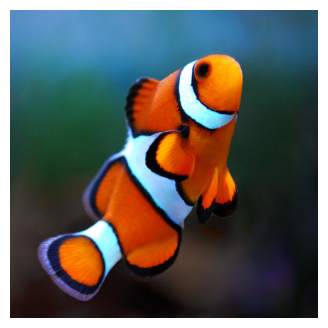

In [14]:
#@title General arguments
#@markdown - **`image`** - Path to input image.
#@markdown - **`weights`** - Path to optimization weights image (optional). Black (0) - high weight, White (1) - low weight.
#@markdown - **`experiment_name`** - Name of experiment/image (optional).
#@markdown - **`multicolor`** - Apply multicolor optimization instead of B&W.

image = 'examples/fish.jpg'  #@param {type:"string"}
weights = ''  #@param {type:"string"}
experiment_name = 'fish_BL'  #@param {type:"string"}
multicolor = True  #@param {type:"boolean"}

result_path = os.path.join('results', os.path.splitext(os.path.basename(image))[0])
debug_path = os.path.join(result_path, experiment_name)
os.makedirs(result_path, exist_ok=True)
os.makedirs(debug_path, exist_ok=True)
verbose = True

if weights == '':
    weights = None

plot_image(image)
if weights:
    plot_image(weights)

In [15]:
#@title Canvas arguments
#@markdown #### Basic params
#@markdown - **`canvas_size`** - Canvas size (h, w) in mm. (Recommended: around (600, 600))
#@markdown - **`nails`** - Number of nails around canvas. (Recommended: 360)
#@markdown - **`shape`** - Shape of the canvas (`ellipse`/`rectangle`).
#@markdown - **`fiber_width`** - Real fiber width in mm. (Recommended: 0.12, but meant to represent the actual thread width)

canvas_size = (600, 600)  #@param
nails = 360  #@param {type:"integer"}
shape = 'rectangle'  #@param ['rectangle', 'ellipse']
fiber_width = 0.12  #@param {type:"number"}

#@markdown #### Advanced params
#@markdown - **`fiber_constant`** - Use constant fiber simulation instead of antialiasing fiber. (Not reommended)
#@markdown - **`bg_color`** - Background color (HEX). Pick color in the interactive cell after running. (Recommended: `#ffffff`, don't forget to click "confirm")
fiber_constant = False  #@param {type:"boolean"}
bg_color = {'value': ['#ffffff']}  # default value
bg_color = pick_n_colors(n=1, default='#ffffff', names=['bg_color'])


In [16]:
#@title Preprocessing arguments
#@markdown - **`optimization_resolution`** - Optional optimization canvas resolution (h, w). Use when image is too big, to resize to around (900, 900).
#@markdown - **`palette`** - Palette calculation method:
#@markdown  - `manual` - manually define palette in the interactive cell after running.
#@markdown  - `rgbcmykw` - choose the best palette from RGBCMYKW color dictionary.
#@markdown  - `patches` - choose the best palette from a predefined COLOR_DICT, by calculating dithering error on small image patches.
#@markdown  - `histogram` - choose palette based on image histogram. (Not recommended)
#@markdown  - `histogram_and_patches` - use histogram method to reduce COLOR_DICT for better efficiency, then use patches simulation method to choose the best palette.
#@markdown  - `clustering` - calculate palette via color clustering methods. (Not recommended)
#@markdown - **`n_colors`** - Number of colors to use for dithering palette.
#@markdown - **`colors`** - Manual palette, list of HEX colors of fibers to use. Pick color in the interactive cell after running. (Don't forget to click "confirm")

optimization_resolution = None  #@param
palette = 'manual'  #@param ['manual', 'rgbcmykw', 'patches', 'histogram', 'histogram_and_patches', 'clustering']
n_colors = 4  #@param {type:"slider", min:1, max:8, step:1}

if palette == 'manual':
    colors = pick_n_colors(n=n_colors)
else:
    colors = None

In [17]:
#@title Optimizer arguments
#@markdown #### Basic params
#@markdown - **`n_fibers`** - Max number of fibers in the canvas. Also works as postprocessing flag to more quickly test the effect of reducing number of fibers.  (Recommended: ~3,000 for B&W, ~10,000 for multicolor)
#@markdown - **`optimizer_type`** - Type of optimizer to use (`greedy`/`LS`/`binary_linear`/`multicolor_binary_linear` - Recommended: `binary_linear`).
n_fibers = 10000  #@param {type:"slider", min:3000, max:15000, step:500}
optimizer_type = 'binary_linear'  #@param ['binary_linear', 'multicolor_binary_linear', 'greedy', 'LS']
assert not (optimizer_type == 'multicolor_binary_linear' and not multicolor), '\'multicolor_binary_linear\' optimizer canot be used for B&W optimization.'

#@markdown #### Advanced params
#@markdown - **`noncontinuous`** - Without this flag, each line will be forced to start from the second nail of the previous line, to form a continuous path. This flag disables enforcing a continuous path. (Not recommended)
#@markdown - **`n_random_nails`** - Limit connections to random subset of nails each iteration. Used mainly for speedup. (Recommended: 150)
noncontinuous = False  #@param {type:"boolean"}
n_random_nails = 150  #@param {type:"slider", min:50, max:400, step:10}


In [18]:
#@title Initialize config
#@markdown **Run this cell after initializing all parmeters to set up the config.**
config = Config(
    canvas=CanvasConfig(
        size=canvas_size,
        nails=nails,
        shape=shape,
        fiber_width=fiber_width,
        fiber_constant=fiber_constant,
        bg_color=image_utils.hex2rgb(bg_color['value'][0]),
    ),
    preprocess=PreprocessConfig(
        resolution=optimization_resolution,
        colors=np.array([image_utils.hex2rgb(color) for color in colors['value']], dtype=np.float32) / 255. if colors else None,
        palette_type=palette,
        n_colors=n_colors,
    ),
    optimizer=OptimizerConfig(
        n_fibers=n_fibers,
        type=optimizer_type,
        multicolor=multicolor,
        continuous=not noncontinuous,
        n_random_nails=n_random_nails,
    )
)

---

## Generate String-Art

Preprocess time: 28.79
Selected color palette:


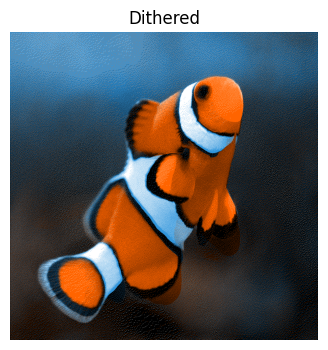

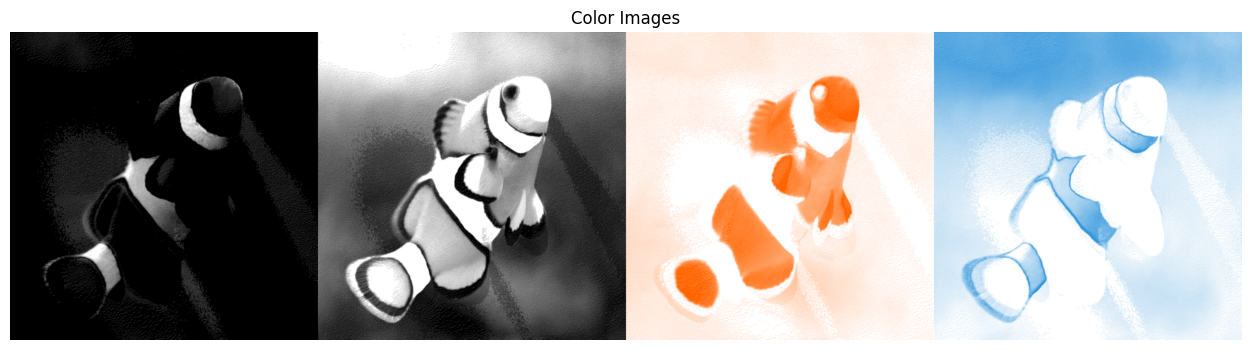

In [19]:
#@title Preprocessing (Optional)
#@markdown This cell isn't mandatory, use it only for debugging the preprocessing phase, and testing the color selection and dithering results before running optimization.
tic = time()
optimizer = optimizer_factory(config)
preprocessed = optimizer.preprocess(image)
preprocess_time = time() - tic
print(f'Preprocess time: {preprocess_time:.2f}')

if config.optimizer.multicolor:
    color_images, dithered = preprocessed
    print('Selected color palette:')
    for c in color_images:
        visualizations.print_with_colorbar(f'{visualizations.COLORBAR_PLACEHOLDER}', c)
    plot_image(dithered, 'Dithered')
    color_image = visualizations.visualize_color_images(color_images, force_horizontal=True)
    plot_image(color_image, 'Color Images')
else:
    plot_image(1 - preprocessed[0], 'Preprocessed Image')

In [20]:
#@title Optimization
#@markdown 🎉🎉🎉 Finally calculating the String-Art! 🎉🎉🎉
optimizer = optimizer_factory(config)
lines = optimizer.optimize(
    image,
    weights=weights,
    callback_it=None,
    debug_path=debug_path,
    verbose=verbose,
    )


Number of lines per color:


Optimizing color #0: 

BinaryLinearOptimizer: 100%|██████████| 461/461 [00:04<00:00, 100.66it/s]


Optimizing color #1: 

BinaryLinearOptimizer: 100%|██████████| 5035/5035 [00:49<00:00, 101.15it/s]


Optimizing color #2: 

BinaryLinearOptimizer: 100%|██████████| 1808/1808 [00:18<00:00, 96.74it/s] 


Optimizing color #3: 

BinaryLinearOptimizer: 100%|██████████| 2696/2696 [00:26<00:00, 101.02it/s]


Preprocessing time: 28.0 sec
Optimization time: 120.7 sec
Total time: 148.7 sec


In [21]:
#@title Postprocessing
#@markdown Run after optimization to create final String-Art piece.

#@markdown You may change the parameters here to test various postprocessing options and choose the best one. Reminder:
#@markdown - **`new_name`** - Optional new experiment name to distinguish between different postprocessing parameter values.
#@markdown - **`n_fibers`** - Max number of fibers in the canvas. Also works as postprocessing flag to more quickly test the effect of reducing number of fibers.  (Recommended: ~3,000 for B&W, ~10,000 for multicolor)
#@markdown - **`simulate_combine`** - The default method for interweaving colors is by a fixed interval (e.g., 25% of color #1, 25% of color #2, 25% of color #3, and again 25% of color #1, and so on). This flag tries another combination method, by choosing the best color to add each step based on error simulation (assuming that lines which decrease the error the most should be on top). Valid only when not using `multicolor_binary_linear` optimizer.
#@markdown - **`interval`** - Interweaving interval to switch between colors when combining (0 < interval <= 1), only for `simulate_combine = False`. (Recommended: 0.1-0.4, only when not using `multicolor_binary_linear` optimizer)
#@markdown - **`save_instructions`** - Save PDF with String-Art instructions to physically make the piece.
#@markdown - **`save_mp4`** - Save MP4 of string-art rendering process.
new_name = ''  #@param {type: "string"}
n_fibers = 10000  #@param {type:"slider", min:3000, max:15000, step:500}
simulate_combine = False  #@param {type:"boolean"}
interval = 0.2  #@param {type:"slider", min:0.1, max:1, step:0.05}
save_instructions = True  #@param {type:"boolean"}
save_mp4 = False  #@param {type:"boolean"}

config.optimizer.n_fibers = n_fibers
config.optimizer.simulate_combine = simulate_combine
config.optimizer.interval = interval
if new_name == '':
    new_name = experiment_name

# Postprocess
lines_obj = FibersPath(lines)
lines_obj.convert_lines_to_path(config.canvas.nails)
if config.optimizer.simulate_combine:
    lines_obj.combine_color_paths(image, config.canvas)
else:
    lines_obj.interweave_color_paths(config.optimizer.interval)
lines_obj.trim_lines(config.optimizer.n_fibers)

# Render
if save_mp4:
    mp4_path = os.path.join(result_path, new_name + MP4_SUFFIX)
    mp4_callback = callbacks.SaveGifCallback(20, mp4_path, resolution=config.canvas.resolution)
else:
    mp4_callback = None
canvas = MulticolorCanvas(config.canvas) if config.optimizer.multicolor else Canvas(config.canvas)
canvas.render(lines_obj.lines, callback=mp4_callback, max_fibers=config.optimizer.n_fibers)
image_path = os.path.join(result_path, new_name + RESULT_SUFFIX)
canvas.save(image_path)
display(download_button(image_path, '📸 Download String-Art image'))
if save_mp4:
    mp4_callback.close()
    display(download_button(mp4_path, '🎥 Download String-Art rendering video'))
if save_instructions:
    pdf_path = os.path.join(result_path, experiment_name + PDF_SUFFIX)
    lines_obj.save_instructions(pdf_path, config.canvas, image_path)
    display(download_button(pdf_path, '📑 Download String-Art instructions PDF'))
plot_image(canvas.get_image(), max_display_height=10)


Output hidden; open in https://colab.research.google.com to view.